# Análise do DataSet CicMalDroid2020

### Aluno: Artur Ricardo Bizon
### Matrícula: 40001016034P5

## Introdução

Este data set está disponível [aqui](http://205.174.165.80/CICDataset/MalDroid-2020/Dataset/). Este dataset contém 11598 amostras de apks, estes apks estão divididos em 5 categorias, sendo elas:
1. Adware
    - Malware que consiste em exibir conteúdos de propaganda, mesmo quando o usuário tenta encerrar o aplicativo. Este tipo de malware além de exibir campanhas publicitárias indesejadas ainda pode roubar informaões senssíveis dos usuários
2. Banking Malware
   - Malware especializado em coletar informações sensíveis de aplicações bancárias
3. SMS Malware
   - Este malware faz uso da exploração do serviço de SMS para realizar ataques, enviar SMSs maliciosos, entre outros
4.  Riskware
   - Aplicações legítimas que podem oferecer riscos aos usuários, caso um agente malicioso explore estas aplicações, este tipo de aplicação pode ser utilizado como porta de entrade de malwars, podendo ser, Adware, Ransoware, entre outros.
5. Benign
   - Aplicações legítimas que não possuem intenções maliciosas

O dataset é composto por APKs, arqivos PCAPs e CSVs que possuem resultados de análisis estáticas e dinâmicas dos aplicativos. Neste trabalho, foram utilizados os arquivos CSVs <i>feature_vectors_static</i> e <i>feature_vectors_syscallsbinders_frequency</i>

## Referências
Samaneh Mahdavifar, Dima Alhadidi, and Ali A. Ghorbani (2022). __Effective and Efficient Hybrid Android Malware Classification Using Pseudo-Label Stacked Auto-Encoder__, Journal of Network and Systems Management 30 (1), 1-34

## Análise do dataset

### Passo 1
Inicialmente são carregadas algumas bibliotecas e definidas algumas funções que serão utilizadas no decorrer do processo.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import Normalizer
import matplotlib
import matplotlib.pyplot as plt



sysCallBinder_csv = "../../dados/feature_vectors_syscallsbinders_frequency_5_Cat.csv"
static_csv = "../../dados/feature_vectors_static.csv"

In [2]:
def normalize_dataframe(df):
    filled = df.fillna(0)
    replaced = filled.replace([True, False], [1, 0])
    filtered = replaced.select_dtypes(include="number")
    return filtered.apply(pd.to_numeric, downcast="integer")

def filter_dataFrame_by_variance(df):
    try:
        selector.fit_transform(df)
        df = df[df.columns[selector.get_support(indices=True)]]
    except ValueError:
        return pd.DataFrame()
    return df

def calculate_nIterations(nCols, nColsChunk):
    iterations = nCols/nColsChunk
    if iterations % 1 > 0:
        iterations = int(iterations) + 1
    return iterations

def get_dataset_cols(datasetPath):
    cols = list(pd.read_csv(datasetPath, nrows=1))
    return cols, len(cols)

def create_file_path(x, y):
    x = x.replace("/", "+")
    x = x.replace("\.", "-")
    y = y.replace("/", "+")
    y = y.replace("\.", "-")
    path = "saida2/{}_X_{}.png".format(x,y)

    return path

No código abaixo são definicos algumas valores para a leitura e limpeza do dataset: 
 - _nColsChunk_ tem a função de indicar quantas colunas serão processadas por vez em cada chunk carregada do arquivo csv 
 - _chunkSize_ informa a quantidade de linhas que o pandas deve ler do arquivo csv para cada chunk
 - _selector_ define um threshold para a limpeza das colunas através do algoritimo VarianceThreshold. Este algoritimo tem a função de eliminar as colunas que tem pouca variação de valores

Os valores _nColsChunk_ e _chunkSize_ podem ser alterados para o controle de memória RAM consumida durante a leitura do dataset, por se tratar de um conjunto de dados grando, o arquivo csv consume um grande volume de memória caso seja carregado de uma única vez. A Configuração atual foi pensada para 16 GB de memória RAM

In [3]:
nColsChunk = 30000
chunkSize = 3000
selector = VarianceThreshold(0.1)

### Passo 2
Neste passo, os dados são carregados. O bloco de código abaixo é responsável por carregar os dados da análise estática pesentes no arquivo csv <i>feature_vectors_static</i>:
Inicialmente é carregado uma parte das colunas do arquivo csv, a quantidade de colunas que serão carregas são definicas pelo valor da variável _nColsChunk_. Assim que são carregadas todas as linhas da parcela das colunas selecionadas, o conjunto de dados parcial passar por um processo de normalização e limpeza das colunas. 
A função _normalize_dataframe_ substitui todos so valores Nan por 0, os valores booleanos True e False recebem valores numérios (1 para True e 0 para False), os dados textuais são eliminados.
Já a função _filter_dataFrame_by_variance_ aplica a filtragem dos dados baseado na variação de valores de determinada coluna, se a variação for igual o inferior a definida como threshold será descartada. Vale ressaltar que esta filtragem é baseada no trabalho de Samaneh, Alhadidi e Ali (2022).

In [4]:
start = 0
end = nColsChunk
counter = 0

cols, nCols = get_dataset_cols(static_csv)
iterations = calculate_nIterations(nCols, nColsChunk)
nColsStatic = nCols

for i in range(iterations):
    colsToUse = cols[start:end]
    dfTemp = None
    counter = 0
    for chunk in pd.read_csv(static_csv, chunksize=chunkSize):
        if counter == 0:
            dfTemp = chunk[colsToUse]
        else:
            dfTemp = pd.concat([dfTemp, chunk[colsToUse]], ignore_index=True)
        counter += 1
        print("Linhas carregadas {}".format(len(dfTemp)))

    dfTemp = normalize_dataframe(dfTemp)
    dfTemp = filter_dataFrame_by_variance(dfTemp)
    if i == 0:
        filteredData = dfTemp
    else: 
        filteredData = pd.concat([filteredData, dfTemp], axis=1)
    
    start = end
    end += nColsChunk
    if end > nCols:
        end = nCols
    

/tmp/ipykernel_4959/1185629542.py:13: DtypeWarning: Columns (28616,31699,32820,32821) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(static_csv, chunksize=chunkSize):


Linhas carregadas 3000


/tmp/ipykernel_4959/1185629542.py:13: DtypeWarning: Columns (28616,31699,32820,32821) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(static_csv, chunksize=chunkSize):


Linhas carregadas 6000


/tmp/ipykernel_4959/1185629542.py:13: DtypeWarning: Columns (28557,28576,28595,28616,31699,32820,32821,36173,36181,36595,36601,36651,36658) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(static_csv, chunksize=chunkSize):


Linhas carregadas 9000


/tmp/ipykernel_4959/1185629542.py:13: DtypeWarning: Columns (28595,28616,31699,32820,32821,36173,36181) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(static_csv, chunksize=chunkSize):


Linhas carregadas 11598


/tmp/ipykernel_4959/1185629542.py:13: DtypeWarning: Columns (28616,31699,32820,32821) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(static_csv, chunksize=chunkSize):


Linhas carregadas 3000


/tmp/ipykernel_4959/1185629542.py:13: DtypeWarning: Columns (28616,31699,32820,32821) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(static_csv, chunksize=chunkSize):


Linhas carregadas 6000


/tmp/ipykernel_4959/1185629542.py:13: DtypeWarning: Columns (28557,28576,28595,28616,31699,32820,32821,36173,36181,36595,36601,36651,36658) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(static_csv, chunksize=chunkSize):


Linhas carregadas 9000


/tmp/ipykernel_4959/1185629542.py:13: DtypeWarning: Columns (28595,28616,31699,32820,32821,36173,36181) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(static_csv, chunksize=chunkSize):


Linhas carregadas 11598


O código abaixo carrega as dados coletados na análise dinâmica dos aplicativos, presentes no arquivo csv <i>feature_vectors_syscallsbinders_frequency</i>. Este conjunto de dados é submetido aos mesmos processos de normalização e limpeza apresentados anteriormente

In [5]:
start = 0
end = nColsChunk
if end > nCols:
    end = nCols

cols, nCols = get_dataset_cols(sysCallBinder_csv)
iterations = calculate_nIterations(nCols, nColsChunk)
nColsDynamic = nCols

for i in range(iterations):
    colsToUse = cols[start:end]
    dfTemp = None
    counter = 0
    for chunk in pd.read_csv(sysCallBinder_csv, chunksize=chunkSize):
        if counter == 0:
            dfTemp = chunk[colsToUse]
        else:
            dfTemp = pd.concat([dfTemp, chunk[colsToUse]], ignore_index=True)
        counter += 1
        print("Linhas carregadas {}".format(len(dfTemp)))

    dfTemp = normalize_dataframe(dfTemp)
    dfTemp = filter_dataFrame_by_variance(dfTemp)
    
    filteredData = pd.concat([filteredData, dfTemp], axis=1)
    
    start = end
    end += nColsChunk
    if end > nCols:
        end = nCols

print("O dataset contém {} linhas".format(len(filteredData))) 
print("Foram carregadas {} colunas, após o filtro restaram {} colunas".format((nColsDynamic+nColsStatic), len(list(filteredData))))
print("A classe {} contém {} amostras".format("Adware", len(filteredData.loc[filteredData["Class"] == 1])))
print("A classe {} contém {} amostras".format("Banking Malware", len(filteredData.loc[filteredData["Class"] == 2])))
print("A classe {} contém {} amostras".format("SMS Malware", len(filteredData.loc[filteredData["Class"] == 3])))
print("A classe {} contém {} amostras".format("Riskware", len(filteredData.loc[filteredData["Class"] == 4])))
print("A classe {} contém {} amostras".format("Benign", len(filteredData.loc[filteredData["Class"] == 5])))


Linhas carregadas 3000
Linhas carregadas 6000
Linhas carregadas 9000
Linhas carregadas 11598
O dataset contém 11598 linhas
Foram carregadas 51092 colunas, após o filtro restaram 561 colunas
A classe Adware contém 1253 amostras
A classe Banking Malware contém 2100 amostras
A classe SMS Malware contém 3904 amostras
A classe Riskware contém 2546 amostras
A classe Benign contém 1795 amostras


###  Passo 3
Após os dados serem carregados adequadamente e devidamente filtrados, é realizado uma nova normalização nos dados, desta vez, os dados são submetidos à normalização _l2_, é aplicado esta normalização nos dados para garantir que todas as colunas ficarão na mesma escala, já que os valores vão varia apenas de 0 até 1

In [6]:
transformer =  Normalizer().fit(filteredData)
dataNorm = transformer.transform(filteredData)
dfNormalized = pd.DataFrame(dataNorm, columns=list(filteredData))
dfNormalized["Class"] = filteredData["Class"].values

### Passo 4
O código abaixo faz um scatterplot de todas as colunas, porém devido ao grande número de colunas, não aconcelho criar todos os gráficos, ja que a quantia de gráficos que serão gerados via ser próxima a 250.000 gráficos. Por isso, no bloco próximo bloco de código apresento apenas alguns gráficos para uma breve análise

In [31]:
legend = {
            1:{"name":"Adware", "marker":"o", "color": "r"},
            2:{"name":"Banking", "marker":"s", "color": "g"},
            3:{"name":"SMS malware", "marker":"P", "color": "b"},
            4:{"name":"Riskware", "marker":"D", "color": "c"},
            5:{"name":"Benign", "marker":"^", "color": "m"}}

keys = list(dfNormalized)
counter = 0
for Xkey in keys:
    for Ykey in keys:
        plt.figure(facecolor='white')
        ax = plt.subplot(111)
        ax.set_title("{} X {}".format(Xkey, Ykey))
        ax.set_xlabel(Xkey)
        ax.set_ylabel(Ykey)
        for category in legend:
            item = legend[category]
            ax.scatter(dfNormalized.loc[dfNormalized["Class"] == category][Xkey], 
            dfNormalized.loc[dfNormalized["Class"] == category][Ykey], s=5, marker=item["marker"], 
            color=item["color"])
        ax.legend(["Adware", "Banking", "SMS Malware", "Riskware", "Benign"], prop={"size": 6}, loc="upper left",
            bbox_to_anchor=(1, 0.5))
        outfile = create_file_path(Xkey, Ykey)
        plt.savefig(outfile, dpi=300, bbox_inches="tight")
        plt.close()        


### Passo 4 (Análise Alternativa)
No código abaixo, são exibidos alguns gráficos cruzando algumas informações com as classes dos atributos, desta forma cada linha colorida que se desenha no gráfico é referente a uma classe, e a extenção desta linha representa a amplitudo dos valores que determinada classe tem sobre determinado atributo

- No gráfico "android.intent.action.BATTERY_CHANGED X Class", é possível identificar um certo interesse dos malwares Adware e Banking em relação a  mudança do estado da bateria do dispositivo, desta forma este atributo se mostra útil em diferenciar malware de aplicações legítimas.

- No gráfico "android.intent.action.BOOT_COMPLETED X Class", pode ser observado que as 3 classes de malware, demonstram interesse no evento de _BOOT_COMPLETED_ demostrado assim uma diferença entre os malwares e aplicativos legítimos.

- No gráfico "android.intent.action.DATA_SMS_RECEIVED X Class", é possível identificar que os malwares da classe SMS Malware possuem grande interação com a ação de recebimento de dados via SMS, o que condiz com a característica do malware, já que são voltados ao SMS. Este gráfico demostrar um grande destaque nesta família de malware, o que pode ser um indicador de um bom atributo para diferenciar malwares SMS de outros.

- O gráfico "cancelNotificationWithTag X Class" apresenta um atributo adequado para diferenciar um banking malware, pois como é possível observar, a linha formada pelos pontos desta classe fica que uma região isolada em relação as outras classes

- No gráfico "clock_gettime x Class" pode ser observado um exemplo de atributo que não contribui para a identificação de um malware, pois como é possível observar, todas as linhas tem quase o mesmo comprimento, isto indica que elas tem valores muito parecidos.

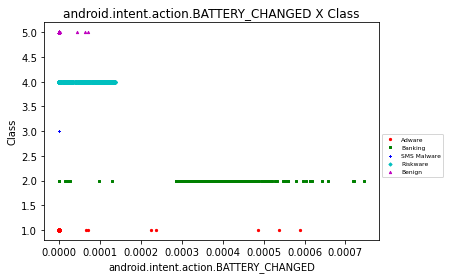

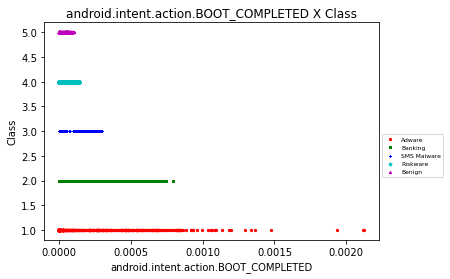

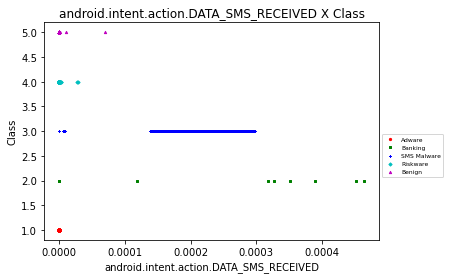

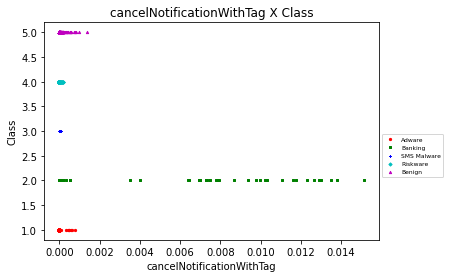

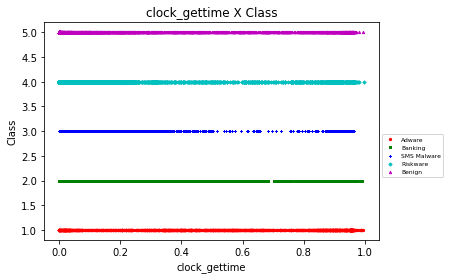

In [8]:
xCols = ["android.intent.action.BATTERY_CHANGED",
"android.intent.action.BOOT_COMPLETED",
"android.intent.action.DATA_SMS_RECEIVED",
"cancelNotificationWithTag",
"clock_gettime"]
Ykey = "Class"
legend = {
            1:{"name":"Adware", "marker":"o", "color": "r"},
            2:{"name":"Banking", "marker":"s", "color": "g"},
            3:{"name":"SMS malware", "marker":"P", "color": "b"},
            4:{"name":"Riskware", "marker":"D", "color": "c"},
            5:{"name":"Benign", "marker":"^", "color": "m"}
        }

for Xkey in xCols:
    plt.figure(facecolor='white')
    ax = plt.subplot(111)
    ax.set_title("{} X {}".format(Xkey, Ykey))
    ax.set_xlabel(Xkey)
    ax.set_ylabel(Ykey)
    for category in legend:
        item = legend[category]
        ax.scatter(dfNormalized.loc[dfNormalized["Class"] == category][Xkey], 
        dfNormalized.loc[dfNormalized["Class"] == category][Ykey], s=5, marker=item["marker"], 
        color=item["color"])
    ax.legend(["Adware", "Banking", "SMS Malware", "Riskware", "Benign"], prop={"size": 6}, loc="upper left",
        bbox_to_anchor=(1, 0.5))
    outfile = create_file_path(Xkey, Ykey)
    plt.show()
    plt.close()  